In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import sys; sys.path.insert(1, 'scripts')
from wildlifeml.utils.io import (
    load_csv, 
    load_json, 
    load_pickle,
)
import results_functions as rf

2022-12-07 00:47:39.478987: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-12-07 00:47:40.363800: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-07 00:47:40.364727: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-07 00:47:40.432777: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:18:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-12-07 00:47:40.433369: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:3b:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-

In [2]:
repo_dir = '/home/charrakho/projects/wildlife-experiments'
image_data_dir = '/common/bothmannl/wildlife_images/usecase2/original_images/'
thresholds_dict = {'ours': 0.252828, 'progressive': 0.5, 'norouzzadeh': 0.9}

In [3]:
cfg = load_json(os.path.join(repo_dir, 'configs/cfg.json'))

label_map = load_json(
    os.path.join(cfg['data_dir'], 'label_map.json')
)

labels = list(label_map.keys())

empty_map = {}
for k, v in label_map.items():
    if k == 'empty':
        empty_map[k] = 'empty'
    else:
        empty_map[k] = 'non_empty'

label_dict = {k: v for k, v in load_csv(os.path.join(cfg['data_dir'], cfg['label_file']))}

detector_dict = load_json(
    os.path.join(cfg['data_dir'], cfg['detector_file'])
)

dataset_ins = load_pickle(os.path.join(cfg['data_dir'], 'dataset_is_test.pkl'))
dataset_oos = load_pickle(os.path.join(cfg['data_dir'], 'dataset_oos_test.pkl'))


df_meta = pd.read_csv(os.path.join(cfg['data_dir'], 'metadata.csv'))
df_meta = df_meta.rename(columns={'orig_name':'img_name'})
df_ins = df_meta[df_meta['station_set']=='s1'].reset_index(drop=True)
df_oos = df_meta[df_meta['station_set']=='s2'].reset_index(drop=True)

# Global

In [4]:
# Relative frequencies of classes in ins & oos & all datasets
df = pd.DataFrame(index=labels)
df['ins'] = rf.get_frequencies(df_ins, label_map, normalize=True)
df['oos'] = rf.get_frequencies(df_oos, label_map, normalize=True)
df['all'] = rf.get_frequencies(df_meta, label_map, normalize=True)
df = df.T
df

,empty,european_hare,others,red_deer,red_fox,red_squirrel,roe_deer,wild_boar
ins,0.641292,0.019903,0.038616,0.001067,0.029054,0.012188,0.249261,0.008618
oos,0.601061,0.010738,0.044256,0.005685,0.004464,0.000547,0.295183,0.038066
all,0.621436,0.015379,0.041400,0.003346,0.016917,0.006443,0.271926,0.023152


In [5]:
# Number of Stations and Images in ins & oos & all datasets
stations_ins = df_ins['station'].unique()
stations_oos = df_oos['station'].unique()
stations_all = df_meta['station'].unique()
df['n_stations'] = [len(stations_ins), len(stations_oos), len(stations_all)]
df['n_images'] = [len(df_ins), len(df_oos), len(df_meta)]

df

,empty,european_hare,others,red_deer,red_fox,red_squirrel,roe_deer,wild_boar,n_stations,n_images
ins,0.641292,0.019903,0.038616,0.001067,0.029054,0.012188,0.249261,0.008618,18,24368
oos,0.601061,0.010738,0.044256,0.005685,0.004464,0.000547,0.295183,0.038066,19,23748
all,0.621436,0.015379,0.041400,0.003346,0.016917,0.006443,0.271926,0.023152,37,48116


In [6]:
# Convert dataframe into the LaTeX foramt
df_tex = rf.prepare_latex(df)

# if max values should be highlighted
s = df_tex.style.highlight_max(
    props=''
    #props='cellcolor:[HTML]{FFFF00}; color:{red}; itshape:; bfseries:;'
)
print(s.to_latex(
    #column_format="rrrrr", 
    position="h", position_float="centering",
    hrules=True, label="table:xxx", caption="Styled LaTeX Table",
    multirow_align="t", multicol_align="r"
))

\begin{table}[h]
\centering
\caption{Styled LaTeX Table}
\label{table:xxx}
\begin{tabular}{lrrrrrrrrrr}
\toprule
 & empty & european\_hare & others & red\_deer & red\_fox & red\_squirrel & roe\_deer & wild\_boar & n\_stations & n\_images \\
\midrule
ins & 0.641292 & 0.019903 & 0.038616 & 0.001067 & 0.029054 & 0.012188 & 0.249261 & 0.008618 & 18 & 24368 \\
oos & 0.601061 & 0.010738 & 0.044256 & 0.005685 & 0.004464 & 0.000547 & 0.295183 & 0.038066 & 19 & 23748 \\
all & 0.621436 & 0.015379 & 0.041400 & 0.003346 & 0.016917 & 0.006443 & 0.271926 & 0.023152 & 37 & 48116 \\
\bottomrule
\end{tabular}
\end{table}



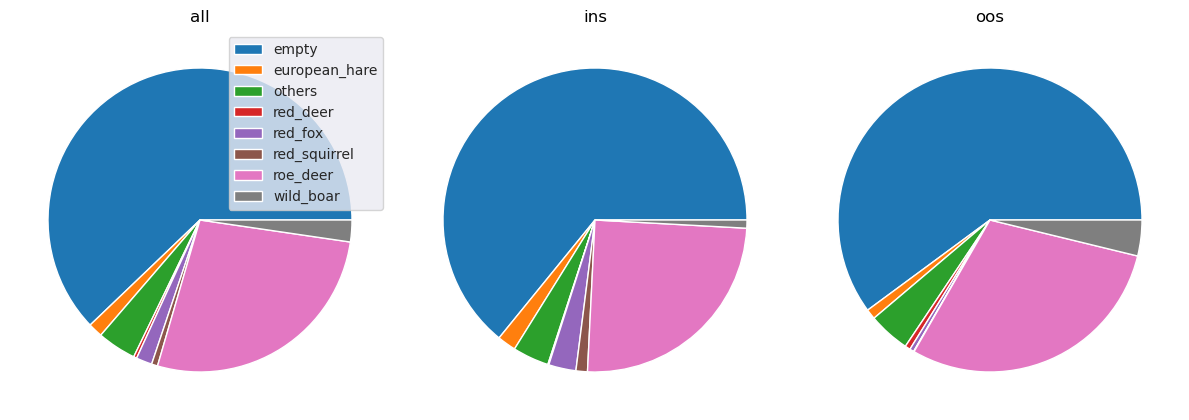

In [7]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(12,5),  tight_layout=True)

for i, (title, df) in enumerate(zip(['all', 'ins', 'oos'], [df_meta, df_ins, df_oos])):
    rf.plot_frequencies(
        df=df, 
        label_map=label_map, 
        ax=ax[i],
    )
    ax[i].set_title(title)
ax[0].legend(labels, loc="best", fontsize=10)
plt.show()
plt.close()

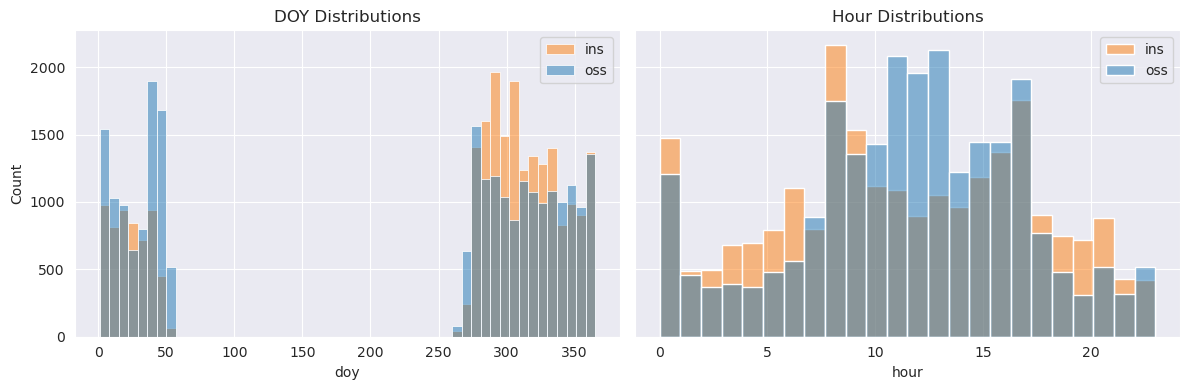

In [8]:
fig, ax = plt.subplots(1,2, figsize=(12,4), sharey=True, tight_layout=True)
sns.histplot(data=df_meta, x='doy', hue='station_set', hue_order=['s1', 's2'], ax=ax[0], bins=52)
ax[0].legend(['ins', 'oss'], loc="best", fontsize=10)
ax[0].set_title('DOY Distributions')

sns.histplot(data=df_meta, x='hour', hue='station_set', hue_order=['s1', 's2'], ax=ax[1], bins=24)
ax[1].legend(['ins', 'oss'], loc="best", fontsize=10)
ax[1].set_title('Hour Distributions')
plt.show()

# IN-SAMPLE

In [9]:
eval_details_path = 'results/202212062336_details_insample_perf.pkl'
eval_details_dict = load_pickle(eval_details_path)

df_pred = rf.build_df_pred(eval_details_dict, label_dict, detector_dict, image_data_dir)
df_pred = rf.labelize_df_pred(df_pred, label_map)
df_pred = pd.merge(df_pred, df_meta, on=['img_name', 'true_class'], how='inner')
df_pred_ins = df_pred.copy()

conf_md = rf.get_binary_confusion_md(
    dataset=dataset_ins, 
    threshold=thresholds_dict['ours'], 
    repo_dir=repo_dir,
)
conf_ppl = rf.get_binary_confusion_ppl(
    y_true=df_pred['true_class'].map(empty_map), 
    y_pred=df_pred['pred_class'].map(empty_map), 
)
pref_b = rf.evaluate_performance(
    y_true=df_pred['true_class'].map(empty_map), 
    y_pred=df_pred['pred_class'].map(empty_map), 
    labels=['non_empty', 'empty'], 
    average=None,
)
pref_m = rf.evaluate_performance(
    y_true=df_pred['true_class'], 
    y_pred=df_pred['pred_class'], 
    labels=labels, 
    average='macro',
)

results_ins = {
    'tnr_md': conf_md.get('tnr'),
    'tpr_md': conf_md.get('tpr'),
    'fnr_md': conf_md.get('fnr'),
    'fpr_md': conf_md.get('fpr'),
    'tnr_ppl': conf_ppl.get('tnr'),
    'tpr_ppl': conf_ppl.get('tpr'),
    'fnr_ppl': conf_ppl.get('fnr'),
    'fpr_ppl': conf_ppl.get('fpr'),
    'acc_b': pref_b.get('acc'),
    'prec_b': pref_b.get('prec')[0],
    'rec_b': pref_b.get('rec')[0],
    'f1_b': pref_b.get('f1')[0],
    'acc_m': pref_m.get('acc'),
    'prec_m': pref_m.get('prec'),
    'rec_m': pref_m.get('rec'),
    'f1_m': pref_m.get('f1'),
}
results_ins

{'tnr_md': 0.9197171381031614,
 'tpr_md': 0.8577680525164114,
 'fnr_md': 0.1422319474835886,
 'fpr_md': 0.0802828618968386,
 'tnr_ppl': 0.7756410256410257,
 'tpr_ppl': 0.9857022708158116,
 'fnr_ppl': 0.014297729184188394,
 'fpr_ppl': 0.22435897435897437,
 'acc_b': 0.9420386409060626,
 'prec_b': 0.9436392914653784,
 'rec_b': 0.9857022708158116,
 'f1_b': 0.9642122583299054,
 'acc_m': 0.8840772818121253,
 'prec_m': 0.8025732120692655,
 'rec_m': 0.8502117710811783,
 'f1_m': 0.8206914948572217}

               precision    recall  f1-score   support

        empty       0.93      0.78      0.85       312
european_hare       0.75      0.74      0.75        62
       others       0.62      0.55      0.58       105
     red_deer       0.75      1.00      0.86         3
      red_fox       0.80      0.95      0.87        82
 red_squirrel       0.93      0.91      0.92        43
     roe_deer       0.92      0.96      0.94       872
    wild_boar       0.71      0.91      0.80        22

     accuracy                           0.88      1501
    macro avg       0.80      0.85      0.82      1501
 weighted avg       0.88      0.88      0.88      1501



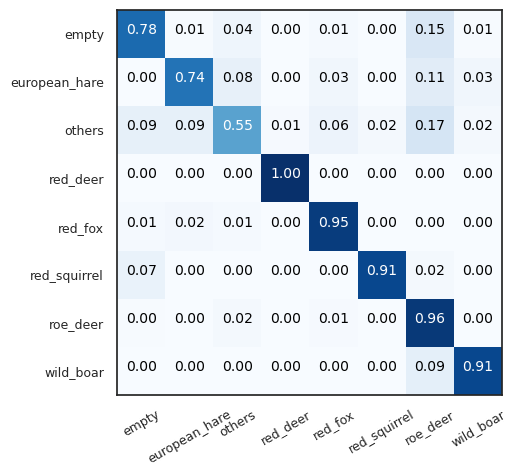

In [10]:
#_paper_
# Table: confusion matrix and recall/precision
report = classification_report(
    y_true=df_pred['true_class'], 
    y_pred=df_pred['pred_class'], 
    labels=labels,
    zero_division=0,
    output_dict=False,
)
print(report)

rf.inspect_confusion(
    df_pred=df_pred, 
    normalize=True, 
    labels=labels, 
    ax=None,
)

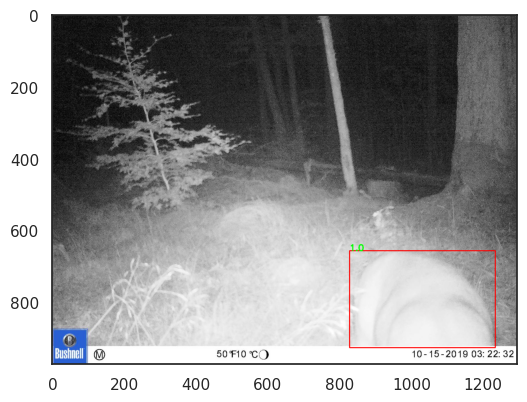

img_name: 11760_10150151.JPG
true_class: roe_deer
pred_class: others
pred_score: 0.683
n_preds: 1
pred_classes: ['others']
pred_confs: [0.683]
md_confs: [1.0]
score_dict: {'others': 0.683, 'roe_deer': 0.253, 'european_hare': 0.037, 'red_fox': 0.014, 'empty': 0.008, 'wild_boar': 0.003, 'red_deer': 0.002, 'red_squirrel': 0.001}


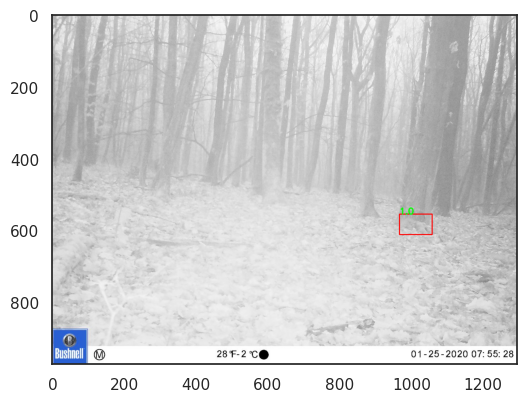

img_name: 18800_01250131.JPG
true_class: roe_deer
pred_class: empty
pred_score: 0.511
n_preds: 1
pred_classes: ['empty']
pred_confs: [0.511]
md_confs: [1.0]
score_dict: {'empty': 0.511, 'roe_deer': 0.478, 'red_fox': 0.007, 'european_hare': 0.002, 'others': 0.001, 'red_deer': 0.0, 'red_squirrel': 0.0, 'wild_boar': 0.0}


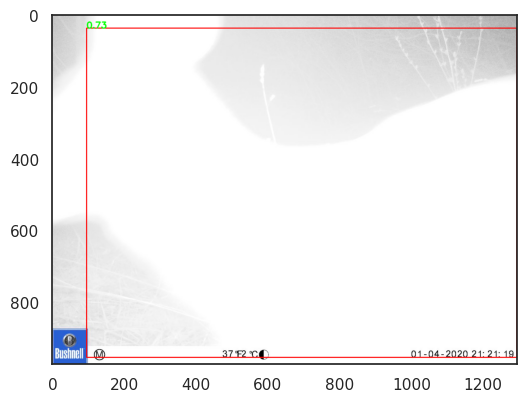

img_name: 30419_01040091.JPG
true_class: roe_deer
pred_class: others
pred_score: 0.95
n_preds: 1
pred_classes: ['others']
pred_confs: [0.95]
md_confs: [0.73]
score_dict: {'others': 0.95, 'roe_deer': 0.046, 'empty': 0.002, 'european_hare': 0.0, 'red_deer': 0.0, 'red_fox': 0.0, 'red_squirrel': 0.0, 'wild_boar': 0.0}


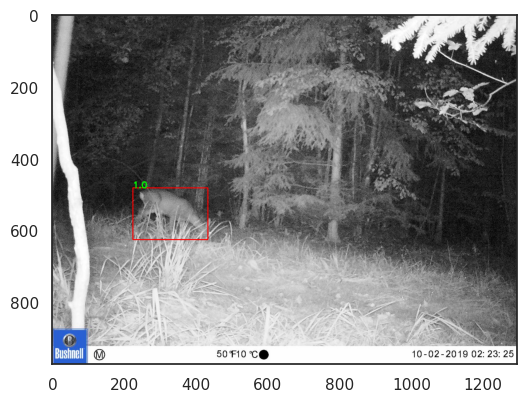

img_name: 49227_10020078.JPG
true_class: roe_deer
pred_class: red_fox
pred_score: 0.551
n_preds: 1
pred_classes: ['red_fox']
pred_confs: [0.551]
md_confs: [1.0]
score_dict: {'red_fox': 0.551, 'roe_deer': 0.244, 'others': 0.198, 'empty': 0.005, 'european_hare': 0.001, 'red_squirrel': 0.001, 'wild_boar': 0.001, 'red_deer': 0.0}


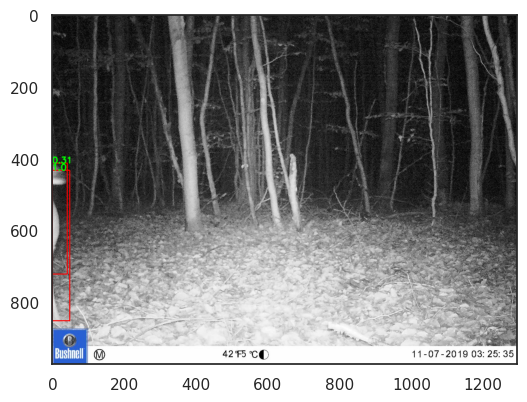

img_name: 8480_11070189.JPG
true_class: roe_deer
pred_class: others
pred_score: 0.559
n_preds: 2
pred_classes: ['roe_deer', 'others']
pred_confs: [0.58, 0.673]
md_confs: [0.31, 1.0]
score_dict: {'others': 0.559, 'roe_deer': 0.382, 'empty': 0.054, 'red_fox': 0.002, 'european_hare': 0.001, 'wild_boar': 0.001, 'red_deer': 0.0, 'red_squirrel': 0.0}


In [11]:
#_paper_

# Perhaps show some missclassified images
rf.inspect_misclasses(
    df_pred=df_pred, 
    test_label='roe_deer', 
    label_map=label_map,
    n_displays=5, 
    is_truth=True,
    sorting='random',
)


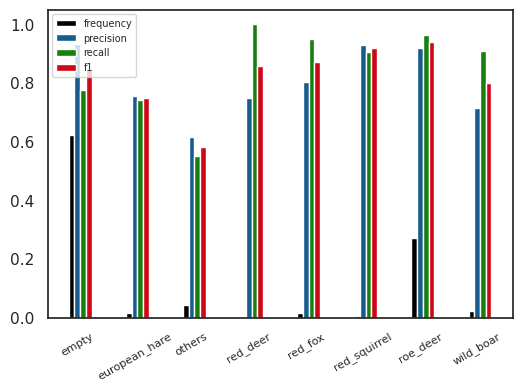

In [12]:
rf.plot_class_performance(
    df_pred=df_pred, 
    df_meta=df_meta, 
    label_map=label_map, 
    ax=None)

# EMPTY VS NON-EMPTY

In [13]:
#_paper_
#Table: rates for 3 different thresholds: 
eval_details_path = 'results/202212062353_details_insample_empty.pkl'
#eval_details_path = 'results/202211251652_details_insample_empty.pkl'
eval_details_dict = load_pickle(eval_details_path)

thresholds = list(thresholds_dict.values())
names = list(thresholds_dict.keys())

df = pd.DataFrame()
df_pred_list = []

for index_tresh, threshold in enumerate(thresholds):
    
    df_pred = rf.build_df_pred(eval_details_dict[threshold], label_dict, detector_dict, image_data_dir)
    df_pred = rf.labelize_df_pred(df_pred, label_map)
    df_pred = pd.merge(df_pred, df_meta, on=['img_name', 'true_class'], how='inner')
    df_pred_list.append(df_pred)
    
    conf_md = rf.get_binary_confusion_md(
        dataset=dataset_ins, 
        threshold=threshold, 
        repo_dir=repo_dir,
    )
    conf_ppl = rf.get_binary_confusion_ppl(
        y_true=df_pred['true_class'].map(empty_map), 
        y_pred=df_pred['pred_class'].map(empty_map),
    )
    pref_b = rf.evaluate_performance(
        y_true=df_pred['true_class'].map(empty_map), 
        y_pred=df_pred['pred_class'].map(empty_map), 
        labels=['non_empty', 'empty'], 
        average=None,
    )
    pref_m = rf.evaluate_performance(
        y_true=df_pred['true_class'], 
        y_pred=df_pred['pred_class'], 
        labels=labels, 
        average='macro',
    )
    results = {
        'tnr_md': conf_md.get('tnr'),
        'tpr_md': conf_md.get('tpr'),
        'fnr_md': conf_md.get('fnr'),
        'fpr_md': conf_md.get('fpr'),
        'tnr_ppl': conf_ppl.get('tnr'),
        'tpr_ppl': conf_ppl.get('tpr'),
        'fnr_ppl': conf_ppl.get('fnr'),
        'fpr_ppl': conf_ppl.get('fpr'),
        'acc_b': pref_b.get('acc'),
        'prec_b': pref_b.get('prec')[0],
        'rec_b': pref_b.get('rec')[0],
        'f1_b': pref_b.get('f1')[0],
        'acc_m': pref_m.get('acc'),
        'prec_m': pref_m.get('prec'),
        'rec_m': pref_m.get('rec'),
        'f1_m': pref_m.get('f1'),
    }
    df_x = pd.DataFrame(data=list(results.values()), index=results.keys())
    df = pd.concat([df, df_x.T], axis=0)

df['names'] = names
df = df.set_index('names')
df


,tnr_md,tpr_md,fnr_md,fpr_md,tnr_ppl,tpr_ppl,fnr_ppl,fpr_ppl,acc_b,prec_b,rec_b,f1_b,acc_m,prec_m,rec_m,f1_m
names,,,,,,,,,,,,,,,,
ours,0.919717,0.857768,0.142232,0.080283,0.862179,0.976451,0.023549,0.137821,0.952698,0.964286,0.976451,0.970330,0.899400,0.829109,0.861376,0.841877
progressive,0.942228,0.818953,0.181047,0.057772,0.897436,0.962994,0.037006,0.102564,0.949367,0.972812,0.962994,0.967878,0.894737,0.800790,0.854708,0.823690
norouzzadeh,0.968685,0.789400,0.210600,0.031315,0.919872,0.947855,0.052145,0.080128,0.942039,0.978299,0.947855,0.962836,0.892738,0.836283,0.836179,0.831049


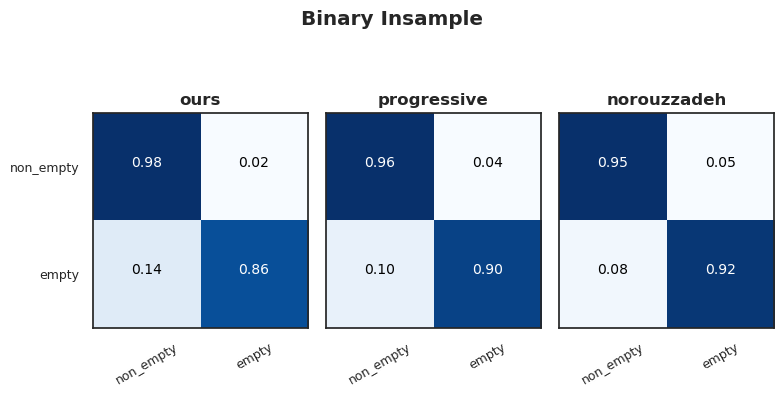

In [14]:
fig, axes = plt.subplots(1,3, figsize=(8, 4), tight_layout=True, sharey=True)

for index_tresh, threshold in enumerate(thresholds):
    ax = axes[index_tresh]
    df_pred = df_pred_list[index_tresh].copy()
    df_pred['true_class'] = df_pred['true_class'].map(empty_map)
    df_pred['pred_class'] = df_pred['pred_class'].map(empty_map)
    rf.inspect_confusion(
        df_pred=df_pred, 
        normalize=True, 
        labels=['non_empty', 'empty'], 
        ax=ax)
    ax.set_title(names[index_tresh], weight='bold')

plt.suptitle("Binary Insample", weight='bold')
plt.show()
plt.close()

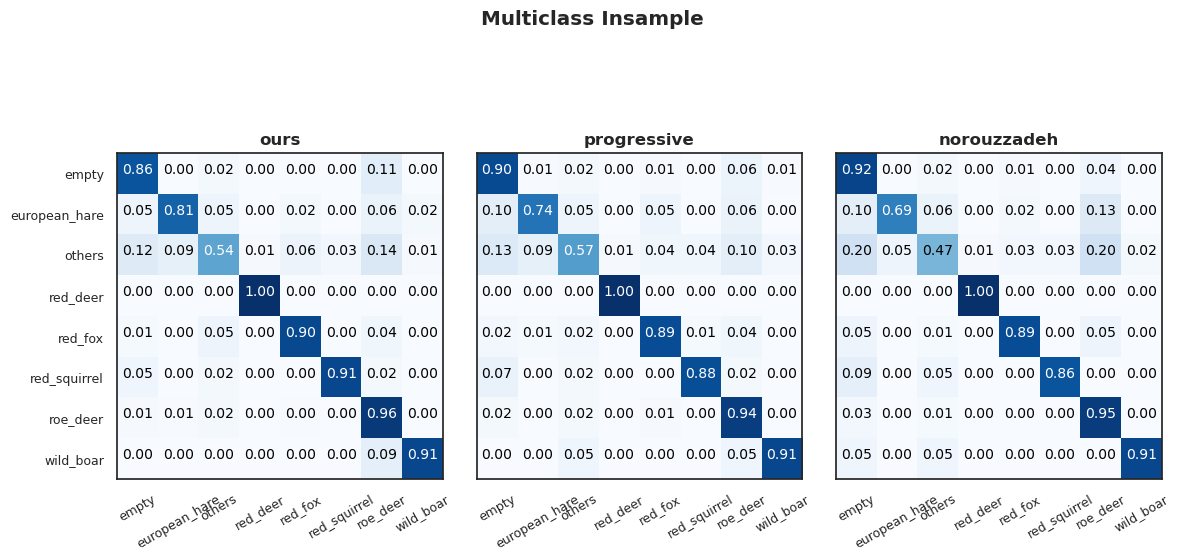

In [15]:
fig, axes = plt.subplots(1,3, figsize=(12, 6), tight_layout=True, sharey=True)

for index_tresh, threshold in enumerate(thresholds):
    ax = axes[index_tresh] 
    rf.inspect_confusion(
        df_pred=df_pred_list[index_tresh], 
        normalize=True, 
        labels=labels, 
        ax=ax)
    ax.set_title(names[index_tresh], weight='bold')
    
plt.suptitle("Multiclass Insample", weight='bold')
plt.show()
plt.close()

In [16]:
#_paper_
#XX% of empty images are correctly detected (TN) 
#only XX% are falsely labeled as empty where in fact they contain animals (FN)
TN = df.loc['ours', 'tnr_ppl'] 
FN = df.loc['ours', 'fnr_ppl']
print(f'{TN:.3}% of empty images are correctly detected')
print(f'{FN:.3}% are falsely labeled as empty')

0.862% of empty images are correctly detected
0.0235% are falsely labeled as empty


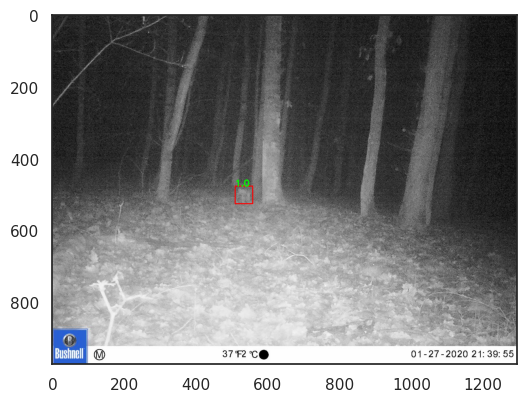

img_name: 18813_01270144.JPG
true_class: non_empty
pred_class: empty
pred_score: 0.583
n_preds: 1
pred_classes: ['empty']
pred_confs: [0.583]
md_confs: [1.0]
score_dict: {'empty': 0.583, 'european_hare': 0.299, 'others': 0.067, 'roe_deer': 0.026, 'red_fox': 0.024, 'red_deer': 0.0, 'red_squirrel': 0.0, 'wild_boar': 0.0}


In [17]:
#_paper_
#Figure: some false non-empties
rf.inspect_misclasses(
    df_pred=df_pred, 
    test_label='empty', 
    label_map=label_map,
    n_displays=1, 
    is_truth=False,
    sorting='descending',
)

# OUT-OF-SAMPLE

In [18]:
eval_details_path = 'results/202212070005_details_oosample_perf.pkl'
eval_details_dict = load_pickle(eval_details_path)

df_pred = rf.build_df_pred(eval_details_dict, label_dict, detector_dict, image_data_dir)
df_pred = rf.labelize_df_pred(df_pred, label_map)
df_pred = pd.merge(df_pred, df_meta, on=['img_name', 'true_class'], how='inner')
df_pred_oos = df_pred.copy()

conf_md = rf.get_binary_confusion_md(
    dataset=dataset_oos, 
    threshold=thresholds_dict['ours'], 
    repo_dir=repo_dir,
)
conf_ppl = rf.get_binary_confusion_ppl(
    y_true=df_pred['true_class'], 
    y_pred=df_pred['pred_class'],
)
pref_b = rf.evaluate_performance(
    y_true=df_pred['true_class'].map(empty_map), 
    y_pred=df_pred['pred_class'].map(empty_map), 
    labels=['non_empty', 'empty'], 
    average=None,
)
pref_m = rf.evaluate_performance(
    y_true=df_pred['true_class'], 
    y_pred=df_pred['pred_class'], 
    labels=labels, 
    average='macro',
)
results_oos = {
    'tnr_md': conf_md.get('tnr'),
    'tpr_md': conf_md.get('tpr'),
    'fnr_md': conf_md.get('fnr'),
    'fpr_md': conf_md.get('fpr'),
    'tnr_ppl': conf_ppl.get('tnr'),
    'tpr_ppl': conf_ppl.get('tpr'),
    'fnr_ppl': conf_ppl.get('fnr'),
    'fpr_ppl': conf_ppl.get('fpr'),
    'acc_b': pref_b.get('acc'),
    'prec_b': pref_b.get('prec')[0],
    'rec_b': pref_b.get('rec')[0],
    'f1_b': pref_b.get('f1')[0],
    'acc_m': pref_m.get('acc'),
    'prec_m': pref_m.get('prec'),
    'rec_m': pref_m.get('rec'),
    'f1_m': pref_m.get('f1'),
}
results_oos

{'tnr_md': 0.9007881316643487,
 'tpr_md': 0.8425096030729834,
 'fnr_md': 0.15749039692701663,
 'fpr_md': 0.09921186833565136,
 'tnr_ppl': 0.5151515151515151,
 'tpr_ppl': 0.9843166542195668,
 'fnr_ppl': 0.01568334578043316,
 'fpr_ppl': 0.48484848484848486,
 'acc_b': 0.8915518274415818,
 'prec_b': 0.8917456021650879,
 'rec_b': 0.9843166542195668,
 'f1_b': 0.9357472488462903,
 'acc_m': 0.7777112043139605,
 'prec_m': 0.5286769628526444,
 'rec_m': 0.5149794925230261,
 'f1_m': 0.5072121790798158}

               precision    recall  f1-score   support

        empty       0.89      0.52      0.65       330
european_hare       0.66      0.66      0.66        41
       others       0.40      0.30      0.34       120
     red_deer       0.00      0.00      0.00        21
      red_fox       0.41      0.50      0.45        22
 red_squirrel       0.25      0.50      0.33         2
     roe_deer       0.80      0.96      0.87      1020
    wild_boar       0.82      0.69      0.75       113

     accuracy                           0.78      1669
    macro avg       0.53      0.51      0.51      1669
 weighted avg       0.77      0.78      0.76      1669



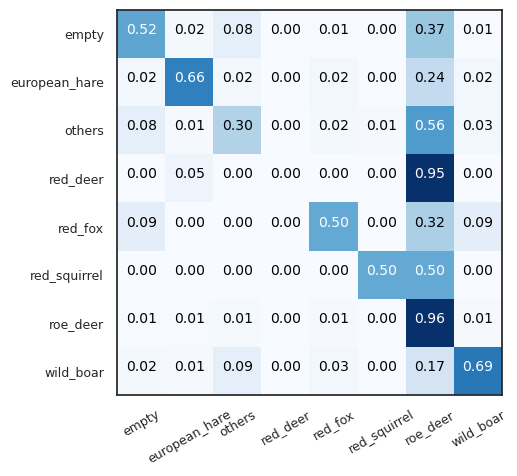

In [19]:
#_paper_

# Table: OOS performance 
report = classification_report(
    y_true=df_pred['true_class'], 
    y_pred=df_pred['pred_class'], 
    labels=labels,
    zero_division=0,
    output_dict=False,
)
print(report)

rf.inspect_confusion(
    df_pred=df_pred, 
    normalize=True, 
    labels=labels, 
    ax=None,
)

In [20]:
#_paper_
# Table: compare INS va. OOS (macro averages)

df = pd.DataFrame(index=list(results_ins.keys()))
df['ins']= results_ins.values()
df['oos']= results_oos.values()
df

,ins,oos
tnr_md,0.919717,0.900788
tpr_md,0.857768,0.842510
fnr_md,0.142232,0.157490
fpr_md,0.080283,0.099212
tnr_ppl,0.775641,0.515152
tpr_ppl,0.985702,0.984317
fnr_ppl,0.014298,0.015683
fpr_ppl,0.224359,0.484848
acc_b,0.942039,0.891552
prec_b,0.943639,0.891746


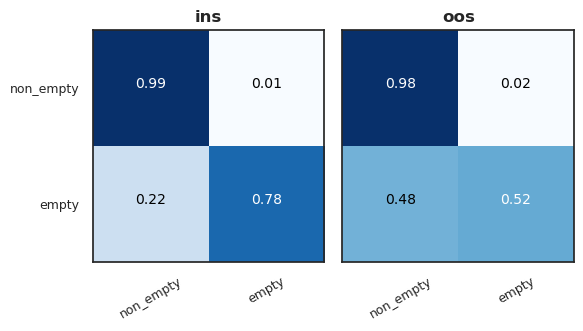

In [21]:
df_pred_ins_b = df_pred_ins.copy()
df_pred_ins_b['true_class'] = df_pred_ins_b['true_class'].map(empty_map)
df_pred_ins_b['pred_class'] = df_pred_ins_b['pred_class'].map(empty_map)

df_pred_oos_b = df_pred_oos.copy()
df_pred_oos_b['true_class'] = df_pred_oos_b['true_class'].map(empty_map)
df_pred_oos_b['pred_class'] = df_pred_oos_b['pred_class'].map(empty_map)


fig, ax = plt.subplots(1, 2, figsize=(6, 4), tight_layout=True, sharey=True)
rf.inspect_confusion(
    df_pred=df_pred_ins_b, 
    normalize=True, 
    labels=['non_empty', 'empty'], 
    ax=ax[0])
ax[0].set_title('ins', weight='bold')

rf.inspect_confusion(
    df_pred=df_pred_oos_b, 
    normalize=True, 
    labels=['non_empty', 'empty'], 
    ax=ax[1])
ax[1].set_title('oos', weight='bold')
plt.show()
plt.close()

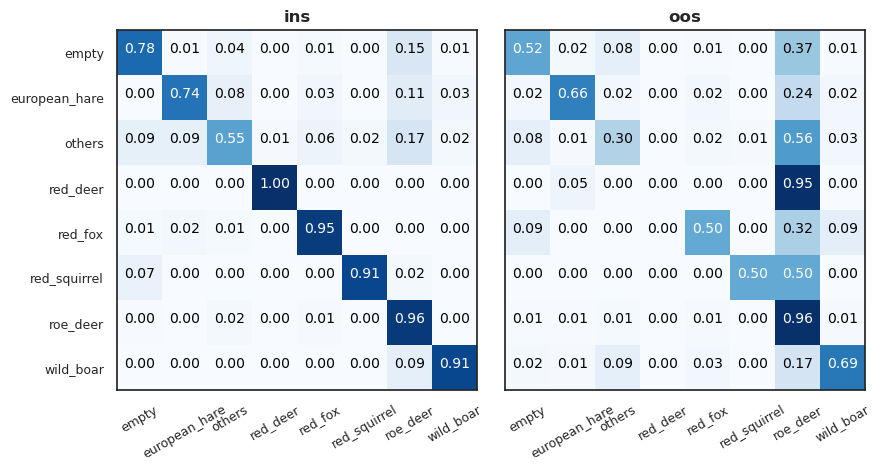

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(9, 6), tight_layout=True, sharey=True)
rf.inspect_confusion(
    df_pred=df_pred_ins, 
    normalize=True, 
    labels=labels, 
    ax=ax[0])
ax[0].set_title('ins', weight='bold')

rf.inspect_confusion(
    df_pred=df_pred_oos, 
    normalize=True, 
    labels=labels, 
    ax=ax[1])
ax[1].set_title('oos', weight='bold')
plt.show()
plt.close()